# Import data

Before starting, you have to make the data avaliable to the script. To do so, your Google Drive folder is mounted into Colab, meaning that we will use Google Drive as a virtual drive where we can access all the resources.

Running the next block, the following message will appear: 

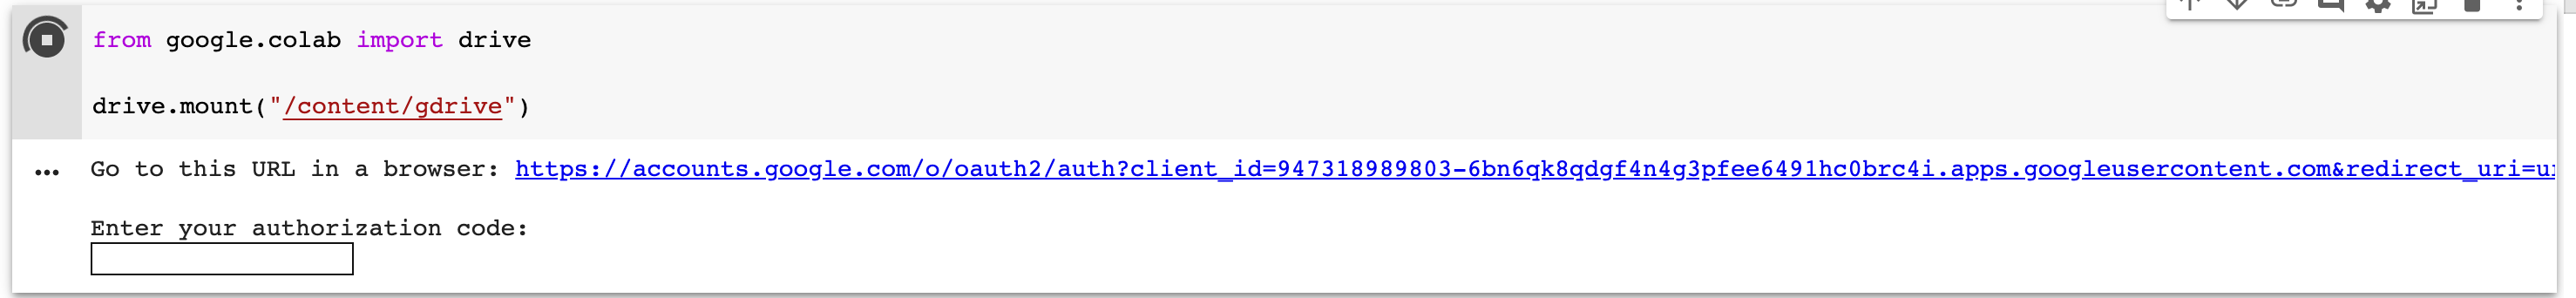

Follow the link and sign in with your Google account. Then copy the given autorization code. Paste it in the text box and press enter. You should see the following message "*Mouted at /content/gdrive*"


This means that you successfully mouneted your Google Drive into Colab. If you want to acces, for example, a test image that is in ```/My Drive/Lab5-Material/```, you should access it through ```/content/gdrive/My Drive/Lab5-Material/test_images.png``` 





In [ ]:
from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


# 1. Anchor generation

In this part of the lab you are asked to compress images with JPEG. Those images will be used as an anchor to compare the perfromance of the autoencoder solution you will design.

To compress images into JPEG we are using the python package ```simplejpeg ``` (https://pypi.org/project/simplejpeg/). It gives the possibility to encode and decode images into JPEG at different quality levels, i.e. with Q factors between 1 and 100.

Below an example of JPEG compression and decompression is given. In particular:
*   ```compressed ``` is the image compressed with JPEG, and corresponds to the file that will be saved in the memory of your device.
*   ```reconstructed ``` is the reconstructed image extracted form the compressed one. 

As JPEG is a **lossy** compression, the reconstructed image will be different from the original.





The next block imports some useful libraries and implements a function to show images in pairs.

In [ ]:
%pip install simplejpeg  # install libjpeg

# import useful libraries
from simplejpeg import decode_jpeg, encode_jpeg, decode_jpeg_header
import cv2
import matplotlib.pyplot as plt
import pandas as pd

# useful function for showing the original and the compressed images
def showPairs(orig, comp, bpp):
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 7), dpi=100, sharex=True, sharey=True)
  ax[0].imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB))
  ax[0].axis('off')
  ax[1].imshow(cv2.cvtColor(comp, cv2.COLOR_BGR2RGB))
  ax[1].set_title("bpp: " +str(bpp))
  ax[1].axis('off')


     |████████████████████████████████| 266kB 8.4MB/s 


The next block implements the encoding and decoding of images with JPEG. The script also saves your reconstructed image and a table with the details of your compressed bitstring in your Google Drive. 

Once you understand the code, you should <font color=”blue”> **compress the images with as much quality levels as possible** </font>, i.e with Q values multiple of 5, using a ```for``` loop. 

*In Python the syntax of loops is different from the one in Matlab. You can find more info at this link: https://wiki.python.org/moin/ForLoop*


In [ ]:
image_names = ['test1.png', 'test2.png', 'test3.png'] # name of the image to compress
# quality_level = 80 #Q value

compressed_details = [] # initialize a list where we will save the details of the images


data_pat = '/content/gdrive/My Drive/Lab5-Material/'
# image = cv2.imread(data_pat+image_name) #read the image

# height, width = image.shape[:2] # get width and height


for image_name in image_names: # run over all test images
  image = cv2.imread(data_pat+image_name) #read the image
  height, width = image.shape[:2]
  for quality_level in range(10, 101, 10): # create Q values as a multiple of 5

    # compress
    compressed = encode_jpeg(image, quality=quality_level) # returns bytes object of encoded image
    bpp_jpeg = (len(compressed)*8)/(width*height) # get the size in bit per pixel 

    # decompress and save the reconstructed image
    reconstructed = decode_jpeg(compressed)
    out_image_name = image_name[:-4]+'_'+str(quality_level)+'.png'
    cv2.imwrite(data_pat+'jpeg/reconstructed/'+out_image_name, reconstructed)

    # show the results
    showPairs(image,reconstructed, bpp_jpeg)

    # create a list with the details of the images
    compressed_details.append([image_name, quality_level, bpp_jpeg])

    # create pandas dataframe from the list, add the header and save it as a .csv
    df = pd.DataFrame(compressed_details, columns =['Image', 'quality', 'bpp']) 
    df.to_csv("/content/gdrive/My Drive/Lab5-Material/jpeg/jpeg_details.csv", sep=',',index=False)

# 2. Autoencoder for image compression

In this section a simple autoencoder solution for image compression is implemented. The presented architecture is the one shown in the lab sheet at figure 8. 

You should first read carefully and understand the proposed implementation. Then you are asked to edit the code and to <font color=”blue”> **create your own architecture** </font>. In order to do it, you need to set: 

*   the number and size of the **hidden layers**;
*   their **activation function**;
*   the number of **epochs** during training.




### **2.1 Import the necessary libraries**

In this section all the relevant libraries are imported.


In [ ]:
import tensorflow.keras.layers
import tensorflow.keras.models
import tensorflow.keras.optimizers  
import tensorflow.keras.datasets
import numpy as np
import matplotlib.pyplot
import tensorflow as tf
import pathlib
import pandas as pd
import cv2

### **2.2 Load the training dataset**
The [CLIC](https://www.compression.cc/challenge/) dataset is used as a training set. It is composed of several uncompressed images, and it is built specifically for deep-learning based data compression. 

To reduce the training time, images have been divided into **small blocks** of size 28x28. Only 60000 crops have been selected as a training set. Morevoer, the three color components are processed separately.

The next blocks implement the code for coping the training set from Google Drive to a new local folder, importing it in Keras and split the tree color components.

In [ ]:
# create a folder where the training set will be stored
%cd /content/
!mkdir dataset
%cd dataset
!mkdir train

# path to the zip training set
%cd "/content/gdrive/My Drive/Lab5-Material/" 

# copy the zip file with the training set to the new local folder
!cp training_set.zip /content/dataset/train 

# unzip the training set
%cd /content/dataset/train
!unzip training_set.zip
!rm -r __MACOSX
!rm training_set.zip

Streaming output truncated to the last 5000 lines.
  inflating: training_set/nigel-lo-550_i25_j3.png  
  inflating: __MACOSX/training_set/._nigel-lo-550_i25_j3.png  
  inflating: training_set/paul-morris-171434_i2_j20.png  
  inflating: __MACOSX/training_set/._paul-morris-171434_i2_j20.png  
  inflating: training_set/yamon-figurs-26140_i16_j32.png  
  inflating: __MACOSX/training_set/._yamon-figurs-26140_i16_j32.png  
  inflating: training_set/ales-krivec-2051_i39_j0.png  
  inflating: __MACOSX/training_set/._ales-krivec-2051_i39_j0.png  
  inflating: training_set/sander-weeteling-88_i54_j18.png  
  inflating: __MACOSX/training_set/._sander-weeteling-88_i54_j18.png  
  inflating: training_set/valor-kopeny-31409_i37_j34.png  
  inflating: __MACOSX/training_set/._valor-kopeny-31409_i37_j34.png  
  inflating: training_set/federico-beccari-130703_i62_j10.png  
  inflating: __MACOSX/training_set/._federico-beccari-130703_i62_j10.png  
  inflating: training_set/ales-krivec-3728_i14_j26.png  

In [ ]:

# import the dataset as variable train_ds
data_dir = "/content/dataset/train/"
data_dir = pathlib.Path(data_dir)

im_size = (28,28)
batch_size = 1

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  label_mode = None,
  seed=123,
  image_size=im_size,
  batch_size=batch_size)

Found 60000 files belonging to 1 classes.


In [ ]:
# separate the three color channels of the training set.

list_train_ds = list(train_ds.as_numpy_iterator())
train_ds_np = np.array(list_train_ds)
train_ds_np_line = train_ds_np.reshape(train_ds_np.shape[0], np.prod(train_ds_np.shape[1:]), order='F')
train_ds_np_line = train_ds_np_line/255

channel_size = int(train_ds_np_line.shape[1]/3)

train_ds_np_r = train_ds_np_line[:,0*channel_size:1*channel_size]
train_ds_np_g = train_ds_np_line[:,1*channel_size:2*channel_size]
train_ds_np_b = train_ds_np_line[:,2*channel_size:3*channel_size]

### **2.3 Create autoencoder architecture**

The next block implements a simple autoencoder architecture for image compression. The implemented architecture is the one shown in the sheet in figure 8. The proposed solution is composed of **3 identical autoencoders**, one for each channel. The  architecture is very simple and includes just one hidden layer of size 500 and activation function ```sigmoid```, and has latent size 10. 

You should start from this template and <font color=”blue”> **build your own architecture** </font>. It can include multiple hidden layers of different sizes. 

Once you decided the best architecture, you should use different sizes of the latent space (```latent_size```) to generate compressed images at **differnt bits per pixel**.


In [ ]:
input_size = 784 # size of the input (do not change this parameter)
latent_size = 80 # size of the latent space
size_hl1 = 512 # size of the first hidden layer
size_hl2 = 256 # size of the second hidden layer
size_hl3 = 128 # site of the third hidden layer

#Create a list of variables used for layers
x_rgb = [] # input

encoder_hl1 = [] # first hidden layer
encoder_hl2 = [] # second hidden layer
encoder_hl3 = [] # third hidden layer
encoder_output = [] # output of the encode
encoder_rgb = [] # model of the encoder

decoder_input = [] # input to the decoder
decoder_hl1 = [] # first hidden layer
decoder_hl2 = [] # second hidden layer
decoder_hl3 = [] # third hidden layer
decoder_output = [] # output
decoder_rgb= [] # model of the decoder

ae_input = []  
ae_encoder_output = []
ae_decoder_output = []

ae_rgb = [] # model of the autoencoder (encoder + decoder)


#For each color channel, create an identical model
for i in range(3):

  #Encoder architecture
  x_rgb.append(tensorflow.keras.layers.Input(shape=(input_size))) # input
  encoder_hl1.append(tensorflow.keras.layers.Dense(units=size_hl1, activation='relu')(x_rgb[i])) # hidden layer 1
  encoder_hl2.append(tensorflow.keras.layers.Dense(units=size_hl2, activation='relu')(encoder_hl1[i])) # hidden layer 2
  encoder_hl3.append(tensorflow.keras.layers.Dense(units=size_hl3, activation='relu')(encoder_hl2[i])) # hidden layer 3
  encoder_output.append(tensorflow.keras.layers.Dense(units=latent_size)(encoder_hl3[i])) # encoder output

  encoder_rgb.append(tensorflow.keras.models.Model(x_rgb[i], encoder_output[i], name="encoder_model")) # build the model


  #Decoder architecture
  decoder_input.append(tensorflow.keras.layers.Input(shape=(latent_size))) # decoder input
  decoder_hl3.append(tensorflow.keras.layers.Dense(units=latent_size, activation='relu')(decoder_input[i])) # hidden layer 3 (counting backwards)
  decoder_hl2.append(tensorflow.keras.layers.Dense(units=size_hl3, activation='relu')(decoder_hl3[i])) # hidden layer 2 (counting backwards)
  decoder_hl1.append(tensorflow.keras.layers.Dense(units=size_hl2, activation='relu')(decoder_hl2[i])) # hidden layer 1 (counting backwards)
  decoder_output.append(tensorflow.keras.layers.Dense(units=input_size)(decoder_hl1[i])) # output
  

  decoder_rgb.append(tensorflow.keras.models.Model(decoder_input[i], decoder_output[i], name="decoder_model")) # build the model

  # Build the autoencoder
  ae_input.append(tensorflow.keras.layers.Input(shape=(input_size), name="AE_input"))
  ae_encoder_output.append(encoder_rgb[i](ae_input[i]))
  ae_decoder_output.append(decoder_rgb[i](ae_encoder_output[i]))

  ae_rgb.append(tensorflow.keras.models.Model(ae_input[i], ae_decoder_output[i], name="AE"))

  #Compile model
  ae_rgb[i].compile(loss="mse", optimizer=tensorflow.keras.optimizers.Adam(lr=0.00005))

### **Train**

The next block implements the training. In Keras, it is done using the function ```fit```.


As introduced in the lab sheet, the ***number of epochs*** is the parameter that defines the number iterations done by the optimization algorithm to find the optimal parameters. If this number is too low, the algorithm will not converge to a solution; if it is too high there is the risk of *overfitting* the data. The optimal number of epochs changes according to the problem and is found experimentally. In this part of the lab, you should **find the best number of epochs** for your architecture. To do it, you can take into consideration the lerning curve plot below. 

In [ ]:
training_epochs = 100
history_r = ae_rgb[0].fit(train_ds_np_r, train_ds_np_r, epochs=training_epochs, batch_size=256, shuffle=True)
history_g = ae_rgb[1].fit(train_ds_np_g, train_ds_np_g, epochs=training_epochs, batch_size=256, shuffle=True)
history_b = ae_rgb[2].fit(train_ds_np_b, train_ds_np_b, epochs=training_epochs, batch_size=256, shuffle=True)

Epoch 1/100
235/235 [==============================] - 1s 4ms/step - loss: 0.0836
Epoch 2/100
235/235 [==============================] - 1s 3ms/step - loss: 0.0103
Epoch 3/100
235/235 [==============================] - 1s 3ms/step - loss: 0.0088
Epoch 4/100
235/235 [==============================] - 1s 3ms/step - loss: 0.0076
Epoch 5/100
235/235 [==============================] - 1s 3ms/step - loss: 0.0071
Epoch 6/100
235/235 [==============================] - 1s 3ms/step - loss: 0.0067
Epoch 7/100
235/235 [==============================] - 1s 3ms/step - loss: 0.0064
Epoch 8/100
235/235 [==============================] - 1s 3ms/step - loss: 0.0061
Epoch 9/100
235/235 [==============================] - 1s 3ms/step - loss: 0.0059
Epoch 10/100
235/235 [==============================] - 1s 3ms/step - loss: 0.0057
Epoch 11/100
235/235 [==============================] - 1s 3ms/step - loss: 0.0056
Epoch 12/100
235/235 [==============================] - 1s 3ms/step - loss: 0.0055
Epoch 13/100


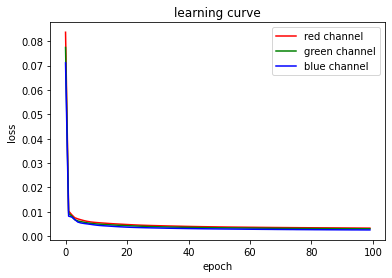

In [ ]:
# this block plots the learning curve 
matplotlib.pyplot.plot(history_r.history["loss"], color='red')
matplotlib.pyplot.plot(history_g.history["loss"], color='green')
matplotlib.pyplot.plot(history_b.history["loss"], color='blue')
matplotlib.pyplot.title('learning curve')
matplotlib.pyplot.ylabel('loss')
matplotlib.pyplot.xlabel('epoch')
matplotlib.pyplot.legend(['red channel', 'green channel', 'blue channel'], loc='upper right')

matplotlib.pyplot.savefig("/content/gdrive/My Drive/Lab5-Material/plots/learning_curve_" + str(training_epochs) + "_" + str(latent_size))
matplotlib.pyplot.show()


### **Encode/Decode**

The next block implements a function that, given an input directory, encodes and decodes all the .png files included in it. It also saves the reconstructed images and the .csv table with all the informations (i.e. the birates).

In [ ]:
def encodeDecode(inputDir, latent):
  #Function that takes all png files on inputDir, encodes and decodes them, and
  #saves the decoded images as png files and a table with the details.

  compressed_details = [] # initialize list for details

  import os
  import PIL
  import glob

  blocksize = 28 

  for inputFilePath in glob.glob(os.path.join(inputDir, '*.png')):

    #Separates filename from path
    inputFile = os.path.split(inputFilePath)[1]

    #Load image
    im = PIL.Image.open(os.path.join(inputDir, inputFile))
    
    # Partition it into blocks

    #Get number of blocks in each dimension, ignoring the last pixels that
    #don't make up a whole block
    i_max = int(im.size[0] / blocksize)
    j_max = int(im.size[1] / blocksize)

    #Initialize numpy array for putting all blocks for each color component
    img_array_r = np.zeros((i_max*j_max, blocksize**2))
    img_array_g = np.zeros((i_max*j_max, blocksize**2))
    img_array_b = np.zeros((i_max*j_max, blocksize**2))

    #Partition image into blocks and saves them
    for i in range(i_max):
      for j in range(j_max):

        #Defines blocks boundaries
        x_init = i * blocksize
        x_end = (i + 1) * blocksize

        y_init = j * blocksize
        y_end = (j + 1) * blocksize

        box = (x_init, y_init, x_end, y_end)

        #Crop image
        region = im.crop(box)

        #Turns crop into numpy array
        np_region = np.array(region)

        #Creates one dimensional array for each color component and scale to 0 - 1
        np_region_line_r = np_region[:,:,0].reshape(int(np_region.size/3), order = 'F')/255
        np_region_line_g = np_region[:,:,1].reshape(int(np_region.size/3), order = 'F')/255
        np_region_line_b = np_region[:,:,2].reshape(int(np_region.size/3), order = 'F')/255

        #Put obtained values on array
        img_array_r[j_max * i + j,:] = np_region_line_r
        img_array_g[j_max * i + j,:] = np_region_line_g
        img_array_b[j_max * i + j,:] = np_region_line_b

    # Compress and decompress all blocks

    #Encode and decode blocks from test image
    encoded_test_image_r = encoder_rgb[0].predict(img_array_r)
    encoded_test_image_g = encoder_rgb[1].predict(img_array_g)
    encoded_test_image_b = encoder_rgb[2].predict(img_array_b)
    # get bpp (note, it will be the same for all images)
    bpp_ae = ((encoded_test_image_r.nbytes + encoded_test_image_g.nbytes + encoded_test_image_b.nbytes)*8)/(im.size[0]*im.size[1])

    decoded_test_image_r = decoder_rgb[0].predict(encoded_test_image_r)
    decoded_test_image_g = decoder_rgb[1].predict(encoded_test_image_g)
    decoded_test_image_b = decoder_rgb[2].predict(encoded_test_image_b)

    # Merge all blocks from test image together

    #Initialize numpy array for putting the decoded image
    img_array = np.zeros((j_max*blocksize, i_max*blocksize, 3))

    for i in range(i_max):
      for j in range(j_max):

        #Defines block boundaries
        x_init = i*blocksize
        x_end = (i + 1)*blocksize

        y_init = j * blocksize
        y_end = (j + 1) * blocksize

        #Takes line corresponding to block and reshapes it into the block format for each color
        block_r = decoded_test_image_r[j_max * i + j].reshape(blocksize, blocksize, order='F')
        block_g = decoded_test_image_g[j_max * i + j].reshape(blocksize, blocksize, order='F')
        block_b = decoded_test_image_b[j_max * i + j].reshape(blocksize, blocksize, order='F')

        #Puts reshaped blocks in final image numpy array
        img_array[y_init:y_end, x_init:x_end, 0] = block_r
        img_array[y_init:y_end, x_init:x_end, 1] = block_g
        img_array[y_init:y_end, x_init:x_end, 2] = block_b

    #Clips image values to 0-1 interval
    img_array_float = img_array
    img_array_float[img_array_float > 1] = 1
    img_array_float[img_array_float < 0] = 0

    #Converts to int and saves as PIL image
    img_array_int = (img_array_float*255).astype(np.uint8)
    decompressed_im = PIL.Image.fromarray(img_array_int)

    #Saves image on disk
    outputDir = inputDir + "/autoencoder/reconstructed/"
    os.makedirs(outputDir, exist_ok = True)
    out_name = inputFile[:-4] + "_" + str(latent) + ".png"
    outputPath = os.path.join(outputDir, out_name)
    decompressed_im.save(outputPath)

    compressed_details.append([out_name, latent, bpp_ae])

  # create pandas dataframe from the list, add the header and save it as a .csv
  df = pd.DataFrame(compressed_details, columns =['Image', 'quality', 'bpp']) 
  df.to_csv(inputDir+"/autoencoder/ae_details_"+str(latent)+".csv", sep=',',index=False)

  return bpp_ae


In the next block, we will use the function ``` encodeDecode ``` to compress and reconstruct all the test images in the folder ``` inputDir ```. Then, the original and reconstructed pairs of the image ``` image_name ``` are shown.

Designing an efficient autoencoder architecture for image compression is **not an easy task**. In particular, the proposed solution is very simple and its performance are not comparable to JPEG. In the state of the art, complex architectures and different learning techniques are applied to obtain good results. In this lab session you will not be evaluated based on the performance of your autoencoder solution, but based on your ability in **designing different architectures** and in **assessing their performance** by understanding how the different parameters **reflects on the visual quality** of the reconstructed image.



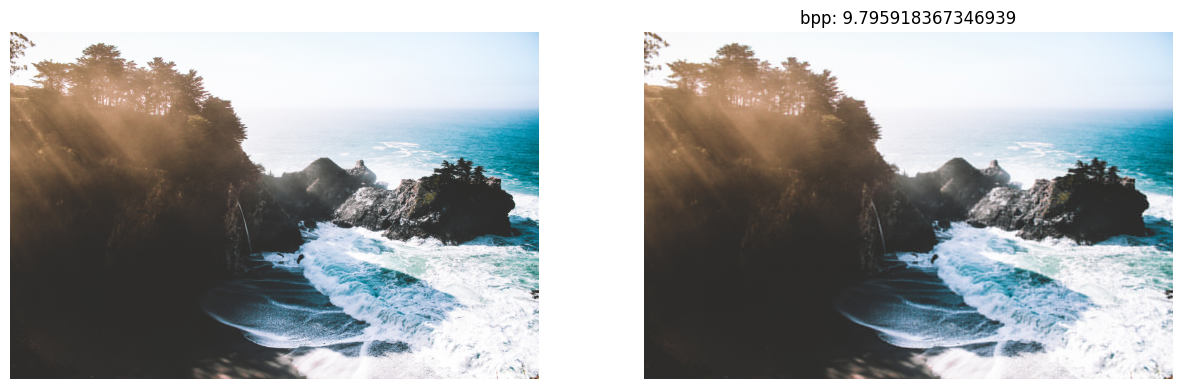

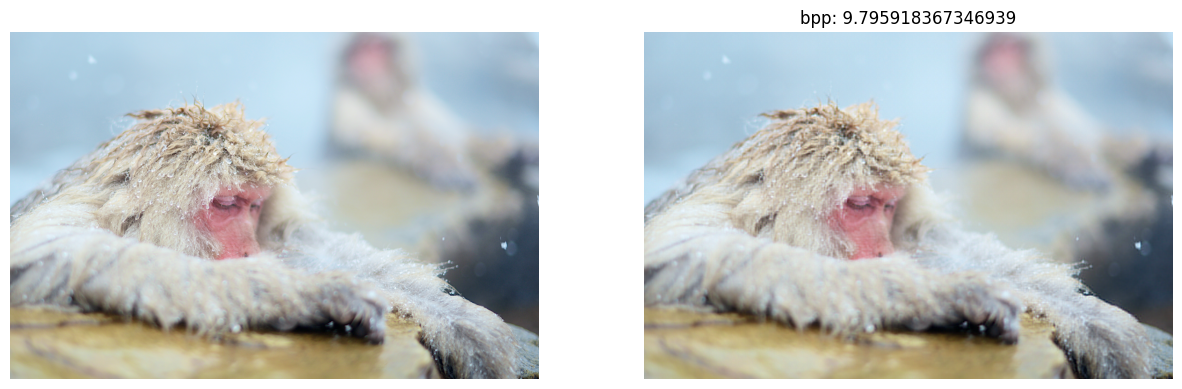

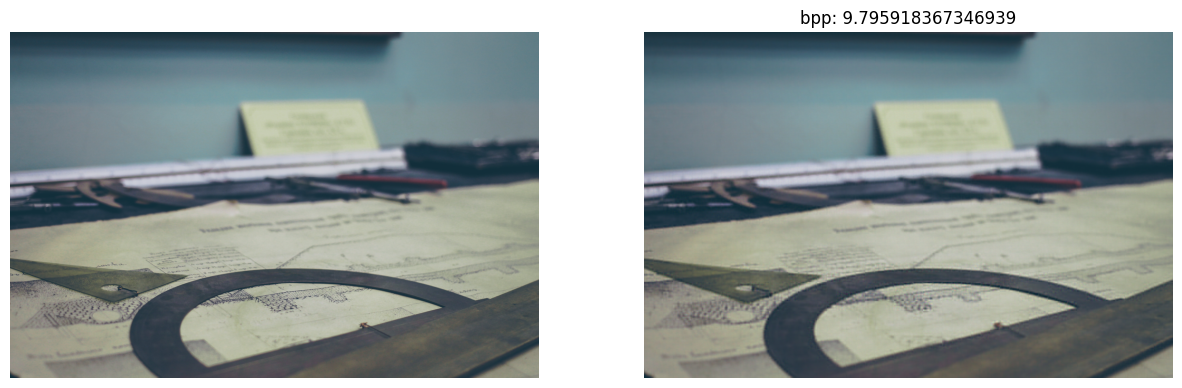

In [ ]:
inputDir = "/content/gdrive/My Drive/Lab5-Material/"
image_names = ["test1", "test2", "test3"]

bpp_ae = encodeDecode(inputDir, latent_size) # encode and reconstruct all the images in the folder
# returns the bpp to show it in the image

for image_name in image_names:
  # show the original and recontructed image
  original = inputDir + image_name + ".png"
  reconstructed = inputDir + "/autoencoder/reconstructed/" + image_name +  "_" + str(latent_size) + ".png"

  original = cv2.imread(original) #read original image
  reconstructed = cv2.imread(reconstructed) #read reconstructed image

  # show the results
  showPairs(original,reconstructed, bpp_ae)


# 3. Objective evaluation

In this part of the lab you are asked to **evaluate** the performance of your autoencoder solution against the performance of the JPEG (anchor). To do it, you need to <font color=”blue”>compute the following **objective metrics**</font> on the decoded data: 
*   PSNR
*   SSIM
*   MS-SSIM
*   VIFP


*In Python, you can compute objective metrics using the **sewar** package.*




In [ ]:
%pip install sewar # install the package

  Created wheel for sewar: filename=sewar-0.4.4-cp36-none-any.whl size=10390 sha256=c209e2e867723666aaa3f6b216bf52b347f06ccb2c689b60758e8e7f35db4fc9
  Stored in directory: /root/.cache/pip/wheels/6b/dd/1f/6bde4832a765007d4f58c9d8bbf82a82b263b7b85e58cbe935
Successfully built sewar


In [ ]:
# Add your code for objective evaluation here.
import sewar.full_ref as full_ref
import csv
import cv2

# filenames of original images
image_names = ['test1', 'test2', 'test3']

data_pat = '/content/gdrive/My Drive/Lab5-Material/'

# auto-encoder values
data_pat_autoencoder = data_pat + 'autoencoder/reconstructed/512_256_128/epochs_100/relu_low_lr/'
data_pat_jpeg = data_pat + 'jpeg/reconstructed/'


with open(data_pat + 'objective/objective_results.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Image", "Compression", "Q/s", "PSNR", "SSIM", "MSSIM", "VIF"])

    for i in range(len(image_names)):
        original = cv2.imread(data_pat + image_names[i] + '.png') #read the image
        if original is None:
          print(data_pat + image_names[i] + '.png')

        # ranges are determined such that compression methods have comparable bpps
        for q_jpeg in range(10, 91, 10):
          reconstructed = cv2.imread(data_pat_jpeg + image_names[i] + '_' + str(q_jpeg) + '.png')
          if reconstructed is None:
            print(data_pat_jpeg + image_names[i] + '_' + str(q_jpeg) + '.png')
          psnr = full_ref.psnr(original, reconstructed)
          ssim = full_ref.ssim(original, reconstructed)[0]
          mssim = float(full_ref.msssim(original, reconstructed))
          vif = full_ref.vifp(original, reconstructed)
          writer.writerow([image_names[i], "jpeg", q_jpeg, psnr, ssim, mssim, vif])

        for q_auto in range(10, 71, 10):
          reconstructed = cv2.imread(data_pat_autoencoder + image_names[i] + '_' + str(q_auto) + '.png')
          if reconstructed is None:
            print(data_pat_autoencoder + image_names[i] + '_' + str(q_auto) + '.png')
          psnr = full_ref.psnr(original, reconstructed)
          ssim = full_ref.ssim(original, reconstructed)[0]
          mssim = float(full_ref.msssim(original, reconstructed))
          vif = full_ref.vifp(original, reconstructed)
          writer.writerow([image_names[i], "auto", q_auto, psnr, ssim, mssim, vif])



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: ComplexWarning: Casting complex values to real discards the imaginary part




After computing the objective metrics, you need to <font color=”blue”>generate the **rate-distortion** plots</font>.


*In Python you can generate plots using the **matplotlib** library.*


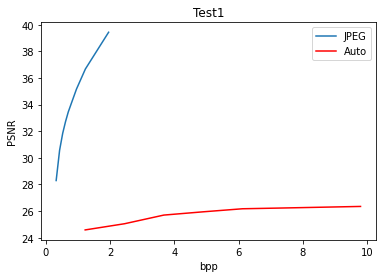

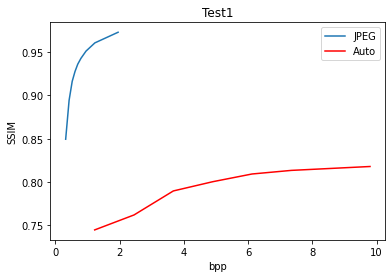

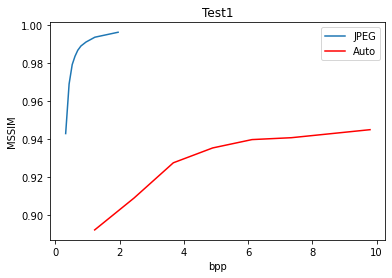

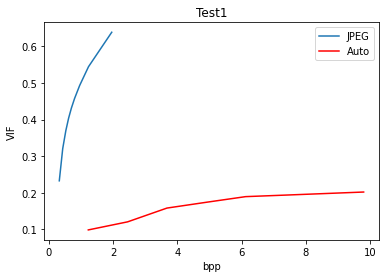

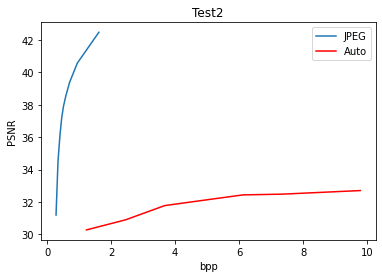

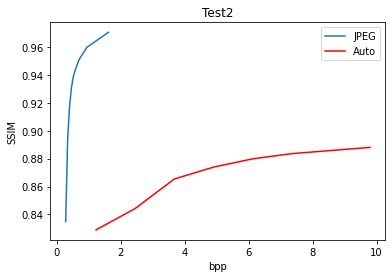

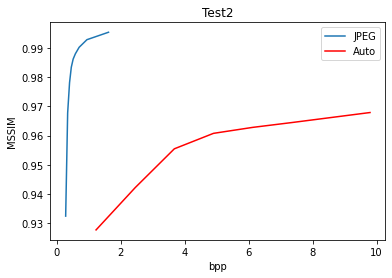

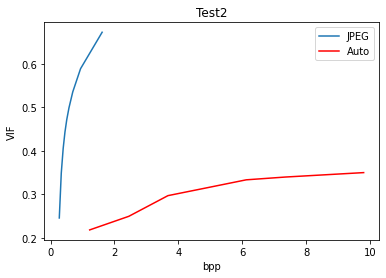

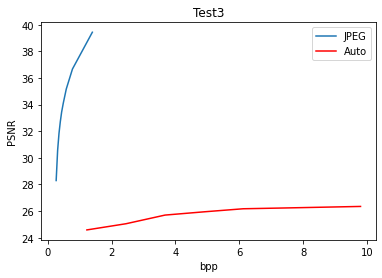

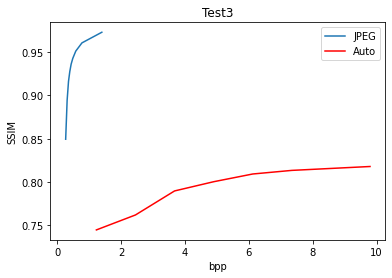

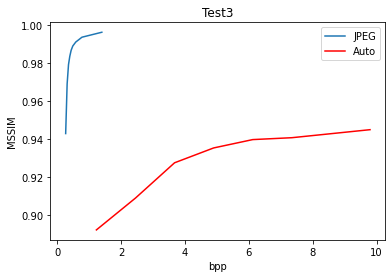

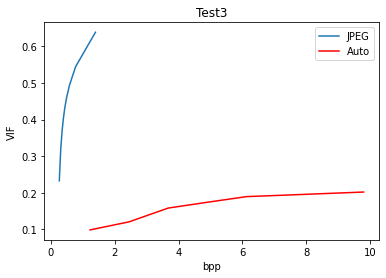

In [ ]:
# Add here the code to generate the rate-distortion plots.
import matplotlib.pyplot as plt
import pandas as pd


data_pat = '/content/gdrive/My Drive/Lab5-Material/objective/'

df = pd.read_csv(data_pat + 'objective_results.csv', sep=';', header=0, index_col=False)
index = df.index
columns = df.columns
values = df.values

test1 = df.iloc[0:16, :]
test2 = df.iloc[16:32, :]
test3 = df.iloc[32:, :]

# test1
for metric in ["PSNR", "SSIM", "MSSIM", "VIF"]:
    brr_jpeg = test1["bpp"].iloc[0:9]
    brr_auto = test1["bpp"].iloc[9:16]
    jpeg_psnr = test1[metric].iloc[0:9]
    auto_psnr = test1[metric].iloc[9:16]
    plt.plot(brr_jpeg, jpeg_psnr)
    plt.plot(brr_auto, auto_psnr, 'r')
    plt.legend(['JPEG', 'Auto'])
    plt.xlabel('bpp')
    plt.ylabel(metric)
    plt.title("Test1")
    plt.savefig(data_pat + 'test1_' + str(metric) + '.png')
    plt.show()

# test2
for metric in ["PSNR", "SSIM", "MSSIM", "VIF"]:
    brr_jpeg = test2["bpp"].iloc[0:9]
    brr_auto = test2["bpp"].iloc[9:16]
    jpeg_psnr = test2[metric].iloc[0:9]
    auto_psnr = test2[metric].iloc[9:16]
    plt.plot(brr_jpeg, jpeg_psnr)
    plt.plot(brr_auto, auto_psnr, 'r')
    plt.legend(['JPEG', 'Auto'])
    plt.xlabel('bpp')
    plt.ylabel(metric)
    plt.title("Test2")
    plt.savefig(data_pat + 'test2_' + str(metric) + '.png')
    plt.show()


# test3
for metric in ["PSNR", "SSIM", "MSSIM", "VIF"]:
    brr_jpeg = test3["bpp"].iloc[0:9]
    brr_auto = test3["bpp"].iloc[9:16]
    jpeg_psnr = test1[metric].iloc[0:9]
    auto_psnr = test1[metric].iloc[9:16]
    plt.plot(brr_jpeg, jpeg_psnr)
    plt.plot(brr_auto, auto_psnr, 'r')
    plt.legend(['JPEG','Auto'])
    plt.xlabel('bpp')
    plt.ylabel(metric)
    plt.title("Test3")
    plt.savefig(data_pat + 'test3_' + str(metric) + '.png')
    plt.show()
